# Q1: Is there seasonality in price?

This is based on **calendar.csv** which includes listing id and the price and availability for a particular day throughout 2016 and some of 2017.


Future work:
* Would be nice if we had more than 1 year to see seasonality 
* This is the price advertised - not the price booked. 
* On availability chart - remove inactive/never available
* Can see a number of really low prices and a few outpliers above 1000 - are these DQ issues? Consider removing these in future analysis.

## Set-up and read in data

In [1]:
## For nicer colours
!pip install colorcet

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from pandas.tseries.offsets import MonthEnd
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# read in data
df_calendar = pd.read_csv('./calendar.csv')

# Set-up colours
palette = sns.color_palette(cc.glasbey, n_colors=17)
# sns.palplot(palette)
sns.set_palette(palette)

# print versions
print("Current version of Python is ", sys.version)
print("Current version of numpy is ",np.__version__)
print("Current version of Pandas is ",pd.__version__)
print("Current version of colorcet is ",cc.__version__)
print("Current version of matplotlib is ",matplotlib.__version__)
print("Current version of seaborn is ",sns.__version__)

     |████████████████████████████████| 1.6 MB 21.5 MB/s            
     |████████████████████████████████| 85 kB 1.4 MB/s             


Matplotlib is building the font cache; this may take a moment.


Current version of Python is  3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Current version of numpy is  1.19.5
Current version of Pandas is  1.1.5
Current version of colorcet is  3.0.0
Current version of matplotlib is  3.3.4
Current version of seaborn is  0.11.1


## Define user functions

In [2]:
# Turn field into binary field
def binary(field, val):
    """Turns a field into a binary columnn. If field = val then 1 else 0. 
        Input: 
            Field = Name of column
            val   = Value that should be classed as 1.
        Output: new binary value
     """
    if field == val:
        out = 1
    else:
        out = 0
    return out

## Look at the data
The cells below tell us that:
* df_calendar 
    * 1,393,570  x 4. 
    * There are 3,818 values of listing_id.
    * Dates should be datetime and price should be float.

In [3]:
# Look at first 5 rows and info and some value counts.

# df_calendar.head() 
# df_calendar.info()
# df_calendar["listing_id"].value_counts()

## Convert columns to correct format
Through above and future analysis I have discovered a few things that need changed and brought it all back here so any additional columns are created in the same place

In [4]:
# Look if all the prices are in dollars before converting

# df_calendar['test'] = df_calendar['price'].astype(str).str[0]
# df_calendar['test'].value_counts()


In [5]:
# Price only populated when the property is available - therefore don't need additional flag so commenting out lines

# df_calendar['price_missing'] =np.where(df_calendar['price'].isnull() , True, False)
# df_calendar['price_missing'].value_counts()
# pd.crosstab(df_calendar['price_missing'], df_calendar['available_01'])

In [6]:
# Change date to date time.
df_calendar["date_dt"]= pd.to_datetime(df_calendar["date"])
# df_calendar.info() - check the conversion didn't change anything to NULL
df_calendar['monthname'] = df_calendar['date_dt'].dt.month_name()
df_calendar['month'] = df_calendar['date_dt'].dt.month
df_calendar['year'] = df_calendar['date_dt'].dt.year
df_calendar['monthend'] = pd.to_datetime(df_calendar['date_dt']) + MonthEnd(1)

# Change fields to binary column
df_calendar['available_01'] = df_calendar.apply(lambda x: binary(x['available'], 't' ), axis = 1)

# Convert to a number
df_calendar['price_new'] = df_calendar['price'].replace('[$,]', '', regex=True).astype(float)

#Drop original columns
df_calendar.drop(['date', 'available', 'price'], axis = 1)

# Remove Jan 2017 as data not complete
only_2016 = df_calendar[df_calendar['monthend'] != '2017-01-31']

only_2016.head()

,listing_id,date,available,price,date_dt,monthname,month,year,monthend,available_01,price_new
0,241032,2016-01-04,t,$85.00,2016-01-04,January,1,2016,2016-01-31,1,85.0
1,241032,2016-01-05,t,$85.00,2016-01-05,January,1,2016,2016-01-31,1,85.0
2,241032,2016-01-06,f,NaN,2016-01-06,January,1,2016,2016-01-31,0,NaN
3,241032,2016-01-07,f,NaN,2016-01-07,January,1,2016,2016-01-31,0,NaN
4,241032,2016-01-08,f,NaN,2016-01-08,January,1,2016,2016-01-31,0,NaN


## Visual analysis

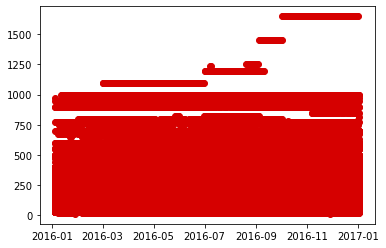

In [7]:
plt.scatter(df_calendar['date_dt'] , df_calendar['price_new'] )
# Obviously not a useful plot but I can quickly see ranges and outliers in the raw values

<AxesSubplot:>

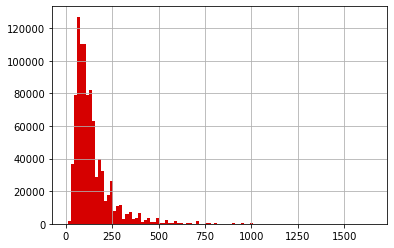

In [8]:
# histogram of prices
df_calendar['price_new'].hist(bins=100)

### Plot the average and room availabilty price per month

In [9]:
# Drop missing prices - these are when the property is not listed
# df_cal_rm_missprice = df_calendar.dropna(subset=['price_dollars_float'])

# Roll-up to date level - mean
df_cal_rollupmean = only_2016.groupby(by="monthname", dropna=False).mean().sort_values(by='month')

# Roll-up to date level - mean
df_cal_rollupsum = only_2016.groupby(by="monthname", dropna=True).count().sort_values(by='month')

df_cal_rollupmean

,listing_id,month,year,available_01,price_new
monthname,,,,,
January,5.550111e+06,1.0,2016.0,0.554133,121.568409
February,5.550111e+06,2.0,2016.0,0.662208,124.293927
March,5.550111e+06,3.0,2016.0,0.709187,128.644488
April,5.550111e+06,4.0,2016.0,0.663847,135.097005
May,5.550111e+06,5.0,2016.0,0.675670,139.538183
June,5.550111e+06,6.0,2016.0,0.674384,147.473137
July,5.550111e+06,7.0,2016.0,0.627097,152.094150
August,5.550111e+06,8.0,2016.0,0.645051,150.656594
September,5.550111e+06,9.0,2016.0,0.674402,143.255949


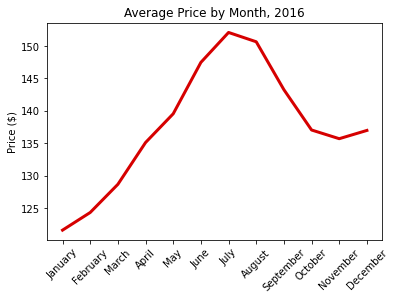

In [10]:
plt.plot(df_cal_rollupmean.index.values, df_cal_rollupmean['price_new'], linewidth=3)
#add title and axis labels
plt.title('Average Price by Month, 2016')
plt.xticks(rotation=45)
# plt.xlabel('Date')
plt.ylabel('Price ($)');


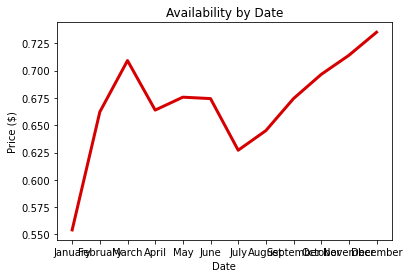

In [11]:
plt.plot(df_cal_rollupmean.index.values, df_cal_rollupmean['available_01'], linewidth=3);
plt.title('Availability by Date')
plt.xlabel('Date')
plt.ylabel('Price ($)');
# not tidy - didn't add to blog in the end